# Data Preparation Part 1

###  Import Libraries and Alias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression, SGDClassifier
from dataframe_column_identifier import DataFrameColumnIdentifier
from sklearn.utils import shuffle
from sklearn.svm import SVC
import time

### Data Intiation

In [2]:
# Data Init
url="https://raw.githubusercontent.com/bensonnd/msds/master/ds7331/data/hotel_bookings.csv"
hotel = pd.read_csv(url)

### New Features

In [3]:

#add `arrival_date` - converting arrival y/m/d columns to a singular column
hotel['arrival_date'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(hotel.arrival_date_year,
                                                                          hotel.arrival_date_month,
                                                                          hotel.arrival_date_day_of_month)])

    # source:
    # https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month

# add `length_of_stay`
    # we will use this as predictor in the classification task, as well as the continuous variable 
    # we want to regress to
hotel['length_of_stay'] = hotel["stays_in_weekend_nights"] + hotel["stays_in_week_nights"]


# set `length_of_stay` as a pandas time delta
length = hotel['length_of_stay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))

    # source:
    # https://stackoverflow.com/questions/42768649/add-days-to-date-in-pandas

    
# add `departure_date` 
hotel['departure_date'] = hotel['arrival_date'] + length


# add `total_revenue`
hotel["total_revenue"] = abs(hotel["adr"]) * hotel["length_of_stay"]


# add `country_cancelation_rate`
    # first we aggregate number of cancelations per country, then divide by total records per country
    # once we have the rate, we join back on country name
hotel['is_canceled_int'] = pd.to_numeric(hotel['is_canceled'])

contry_cancellation_rate_df = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].count())

contry_cancellation_rate_df.columns = ['country_count']
contry_cancellation_rate_df['cancelations'] = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].sum())

contry_cancellation_rate_df['country_cancelation_rate'] = contry_cancellation_rate_df['cancelations'] / contry_cancellation_rate_df['country_count']

hotel = hotel.join(contry_cancellation_rate_df, on='country')

total_cancelations = hotel.is_canceled_int.sum()


# add `stays_in_week_nights_bool` and `stays_in_weekend_nights`
# by changing `stays_in_week_nights` and `stays_in_weekend_nights` to Boolean
hotel['stays_in_week_nights_bool'] = np.where(hotel['stays_in_week_nights']>0, 1, 0)
hotel['stays_in_weekend_nights_bool'] = np.where(hotel['stays_in_weekend_nights']>0, 1, 0)


# add `company_booking_bool` by changing `company` to Boolean
hotel['company'] = hotel['company'].fillna(0)
hotel['company_booking_bool'] = np.where(hotel['company']>0, 1, 0)


# add `used_agent_bool` by changing `agent` to Boolean
hotel['agent'] = hotel['agent'].fillna(0)
hotel['used_agent_bool'] = np.where(hotel['agent']>0, 1, 0)


# add `right_room_bool`
hotel['right_room_bool'] = np.where((hotel['reserved_room_type'].astype(str)==hotel['assigned_room_type'].astype(str)), 1, 0)


# add `previously_canceled_bool` by changing `previous_cancellations` to Boolean
hotel['previously_canceled_bool'] = hotel['previous_cancellations'].astype(bool).astype(int)


# add `lead_time_cat` by descretizing `lead_time`
    # `lead_time` categories 0 days to 1 week, 1 week to 1 month, 1 month to 6 months, greater than 6 months
hotel['lead_time_cat'] = pd.cut(hotel['lead_time'], bins=[0,7,31,180,737],
                labels=['booked_wk_out', 'booked_mnth_out', 'booked_6_mnths_out', 'booked_long'])


# add `country_group_cat` changed to top_ten and other_country by grouping the top 10 countries, and all others
hotel['country_group_cat'] = hotel['country'].apply(lambda x: 'top_ten' 
                                                      if x in ['PRT','GBR','BEL', 'NLD', 'DEU','ESP', 'ITA', 'IRL', 'BRA', 'FRA'] 
                                                      else 'other_country')


# add `parking_space_required_bool` by changing `required_car_parking_spaces` to Boolean
hotel['parking_space_required_bool'] = np.where(hotel['required_car_parking_spaces']>0, 1, 0)

### Dropping Redundant or Unneeded Attributes

In [4]:
# drop the unneeded temp columns created in order to create `country_cancelation_rate`
hotel = hotel.drop(['country_count','cancelations','is_canceled_int'], axis=1)


# dropping redundant date columns as this data is now available in `arrival_date`
hotel = hotel.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month'], axis=1)


# dropping redundant stay length columns as this data is now available in 
# `stays_in_week_nights_cat` and `stays_in_weekend_nights_cat`
hotel = hotel.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)


# dropping redundant columns that changed to boolean or categorical or in grouped attributes
hotel = hotel.drop(['company','agent', 'lead_time', 'country', 
                    'previous_cancellations', 'required_car_parking_spaces'], axis=1)

# dropping redundant columns `reservation_status` as it's nearly identical to `is_canceled` - the target in classification
hotel = hotel.drop(['reservation_status'], axis=1)

In [5]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   arrival_date_week_number        119390 non-null  int64         
 3   adults                          119390 non-null  int64         
 4   children                        119386 non-null  float64       
 5   babies                          119390 non-null  int64         
 6   meal                            119390 non-null  object        
 7   market_segment                  119390 non-null  object        
 8   distribution_channel            119390 non-null  object        
 9   is_repeated_guest               119390 non-null  int64         
 10  previous_bookings_not_canceled  119390 non-null  int64  

### Finding Missing Values

In [6]:
hotel.columns[hotel.isnull().any()].tolist()

['children', 'country_cancelation_rate', 'lead_time_cat']

### Handling Missing Values

In [7]:
# replacing missing values for categorical attributes to 'Unknown'
cat_cols = ['lead_time_cat']
hotel[cat_cols] = hotel[cat_cols].replace({np.nan:'Unknown'})

# replacing missing values for continuous attributes to 0
con_cols = ['children', 'country_cancelation_rate']
hotel[con_cols] = hotel[con_cols].replace({np.nan:0})

    # Source:
    # https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan                                  

In [8]:
# missing columns sanity check
assert len(hotel.columns[hotel.isnull().any()].tolist()) == 0  

### Checking for duplicates

In [9]:
#check for duplicate rows
dups = hotel.duplicated().sum()

    # source:
    # https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe

In [10]:
f"{round(dups/len(hotel)*100,2)}% of all records are considered duplicates"

'27.2% of all records are considered duplicates'

This is a lot. However, the data has been scrubbed any sort of granularity related to the customer attached to each booking, such as an ID or even loyaltly tier. We will assume that duplicates are simply representations of multiple bookings by different customers on the same day, and proceed without removing the duplicates.

In [11]:
#check for duplicate columns
hotel.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

### Use Proper Variable Representations

In [12]:
# converting these columns to string type
hotel[cat_cols] = hotel[cat_cols].astype(str)

# converting `babies` to int since you can't have a half a baby
hotel['babies'] = hotel['babies'].astype(int)


#make all adr (average daily rate) values positive. (only one is actually negative)
hotel['adr'] = hotel['adr'].abs()

# list of continuous attributes
hotel_continuous = ['arrival_date_week_number','adults','children',
                    'babies','is_repeated_guest','previous_bookings_not_canceled',
                    'booking_changes','days_in_waiting_list','adr','total_of_special_requests',
                    'length_of_stay','total_revenue','country_cancelation_rate']

# hotel df of continuos variables in the data set
hotelCont = hotel[hotel_continuous]


# list of categorical attributes
hotel_categoricals =  ['hotel','is_canceled','meal','market_segment','distribution_channel',
                       'reserved_room_type','assigned_room_type','deposit_type','customer_type',
                       'stays_in_week_nights_bool','stays_in_weekend_nights_bool',
                       'company_booking_bool','used_agent_bool','right_room_bool','previously_canceled_bool',
                       'lead_time_cat','country_group_cat','parking_space_required_bool']

# setting categoricals as that type.
for cat in hotel_categoricals:
  hotel[cat] = hotel[cat].astype('category')


# hotel df of categorical variables
hotelCats = hotel[hotel_categoricals]


# converting reservation_status_date to datetime
hotel['reservation_status_date'] = pd.to_datetime(hotel['reservation_status_date'])


# hotel df of datetime variables
hotelDates = hotel.select_dtypes(include=['datetime64'])

### Identifying and Removing Outliers

In [13]:
#######################################
#
# Normalized the entire data set here only to identify and remove outliers. We'll later split the data prior to scaling, and
# and will then normalize the test and training splits separately to avoid data snooping.
#
#######################################

# Mean Normalization of the Continous Variables -  still contains large outliers pictured in graphs below
hotelCont_mean_normed = (hotelCont-hotelCont.mean())/(hotelCont.std())

# Removing outliers greater than 5 standard deviations away
hotel_nol = hotelCont_mean_normed[(np.abs(hotelCont_mean_normed) < 5).all(axis=1)]


# Grabbing indices of the non-outlier rows
no_outlier_indices = pd.DataFrame(hotel_nol.index)
no_outlier_indices.rename(columns={0: "indices"}, inplace=True)
# no_outlier_indices

# This data set has removed the outliers and un-normed the data so that we can use it without snooping on our test data
hotel_no_outliers = pd.concat([hotelCont, hotelCats], axis = 1, join = 'inner')
hotel_no_outliers = hotel_no_outliers.iloc[no_outlier_indices.indices,]

# resetting the dataframe index and dropping the extra column it creates
hotel_no_outliers.reset_index(drop=True, inplace=True)

### Define and prepare class variables

<ul>We are going to predict cancelations (`is_canceled`), either a reservation canceled or did not cancel. This is a binary response, and is categorical, so this is a classification problem.<br><br>
    `is_canceled`, our target for the classification task, was not balanced or downsampled and we did not do any adjustment/prep of the class variable specifically because we have data directly from the hotels' databases for a 3 year period; a substantially large data set. Also, this is a large enough sample that we feel it is representative of the population of the hotels' records. Aproximately 30% of the records are cancelations. Any adjustments to scaling or normalization will be addressed after we split for train/test to avoid data snooping on the full data set.</ul>
<ul>___________________________________________________________________________</ul>
  
<ul>Added new continuous variable `length_of_stay`. We will regress to this in our regression task.</ul>


```python
# add `length_of_stay`
    # we will use this as predictor in the classification task, as well as the continuous variable 
    # we want to regress to
hotel['length_of_stay'] = hotel["stays_in_weekend_nights"] + hotel["stays_in_week_nights"]


# set `length_of_stay` as a pandas time delta
length = hotel['length_of_stay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))

    # source:
    # https://stackoverflow.com/questions/42768649/add-days-to-date-in-pandas
```

#### Setting Target and Predictors

In [14]:
# classification task
data_clf = hotel_no_outliers.loc[:, hotel_no_outliers.columns != 'is_canceled']
target_clf = hotel_no_outliers['is_canceled']

# regression task
data_reg = hotel_no_outliers.loc[:, hotel_no_outliers.columns != 'length_of_stay']
target_reg = hotel_no_outliers['length_of_stay']

### One Hot Encoding Categorical Variables

In [15]:
# classification task
data_clf = pd.get_dummies(data_clf, drop_first=True)
data_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112151 entries, 0 to 112150
Data columns (total 66 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_date_week_number          112151 non-null  int64  
 1   adults                            112151 non-null  int64  
 2   children                          112151 non-null  float64
 3   babies                            112151 non-null  int32  
 4   is_repeated_guest                 112151 non-null  int64  
 5   previous_bookings_not_canceled    112151 non-null  int64  
 6   booking_changes                   112151 non-null  int64  
 7   days_in_waiting_list              112151 non-null  int64  
 8   adr                               112151 non-null  float64
 9   total_of_special_requests         112151 non-null  int64  
 10  length_of_stay                    112151 non-null  int64  
 11  total_revenue                     112151 non-null  f

In [16]:
# regression task
data_reg = pd.get_dummies(data_reg, drop_first=True)
data_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112151 entries, 0 to 112150
Data columns (total 66 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_date_week_number          112151 non-null  int64  
 1   adults                            112151 non-null  int64  
 2   children                          112151 non-null  float64
 3   babies                            112151 non-null  int32  
 4   is_repeated_guest                 112151 non-null  int64  
 5   previous_bookings_not_canceled    112151 non-null  int64  
 6   booking_changes                   112151 non-null  int64  
 7   days_in_waiting_list              112151 non-null  int64  
 8   adr                               112151 non-null  float64
 9   total_of_special_requests         112151 non-null  int64  
 10  total_revenue                     112151 non-null  float64
 11  country_cancelation_rate          112151 non-null  f

### Use Pre-processing methods for dimensionality reduction, scaling, etc.

#### Splitting the Data for Validation

In [17]:
#setting a global number of jobs for parallel processing in the rest of the notebook
nj = -1

In [18]:
# classification task
# using StratifiedShuffleSplit to split into train/test and validatin set to maintain class balance for classification task
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=24)

data_Array_clf, target_Array_clf = data_clf.to_numpy(), target_clf.to_numpy()

# split into training/validation and test sets
for train_val_index, test_index in sss.split(data_Array_clf, target_Array_clf):
    train_val_data_clf, test_data_clf = data_Array_clf[train_val_index], data_Array_clf[test_index]
    train_val_target_clf, test_target_clf = target_Array_clf[train_val_index], target_Array_clf[test_index]

    
# regression task
train_val_data_reg, test_data_reg, train_val_target_reg, test_target_reg = train_test_split(data_reg, target_reg, test_size=0.2, train_size=0.8, random_state=24)


#### Scaling the Data

In [19]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()


# classification Task
# Train/Validation and Test Sets
scl_clf = scl.fit(train_val_data_clf)

# scaling the training and validation set
train_val_data_clf = scl_clf.transform(train_val_data_clf)

# scaling the test set
test_data_clf = scl_clf.transform(test_data_clf)


# regression Task  - 
# Train/Validation and Test Sets
scl_reg = scl.fit(train_val_data_reg)

# scaling the training and validation set
train_val_data_reg = scl_reg.transform(train_val_data_reg)

# scaling the test set
test_data_reg = scl_reg.transform(test_data_reg)

#### Further Splitting into Train and Validation

In [20]:
# splitting into training and validation sets

# regression Task
# Train and Validation Sets
train_data_reg, validation_data_reg, train_target_reg, validation_target_reg = train_test_split(train_val_data_reg, train_val_target_reg, test_size=0.2, train_size=0.8, random_state=24)


# forming into dataframes and renaming
training_data_reg = pd.DataFrame(train_data_reg, columns = data_reg.columns)
validation_data_reg = pd.DataFrame(validation_data_reg, columns = data_reg.columns)
test_data_reg = pd.DataFrame(test_data_reg, columns = data_reg.columns)

training_target_reg = pd.DataFrame(train_target_reg, columns = ['length_of_stay'])
validation_target_reg = pd.DataFrame(validation_target_reg, columns = ['length_of_stay'])
test_target_reg = pd.DataFrame(test_target_reg, columns = ['length_of_stay'])


### Dimensionality Reduction - Removing Variables that are Not Needed/Useful for Analysis
When looking at the source data, we don't see a lot of highly correlated variables and because of this, we will not be using PCA for dimensionality reduction.

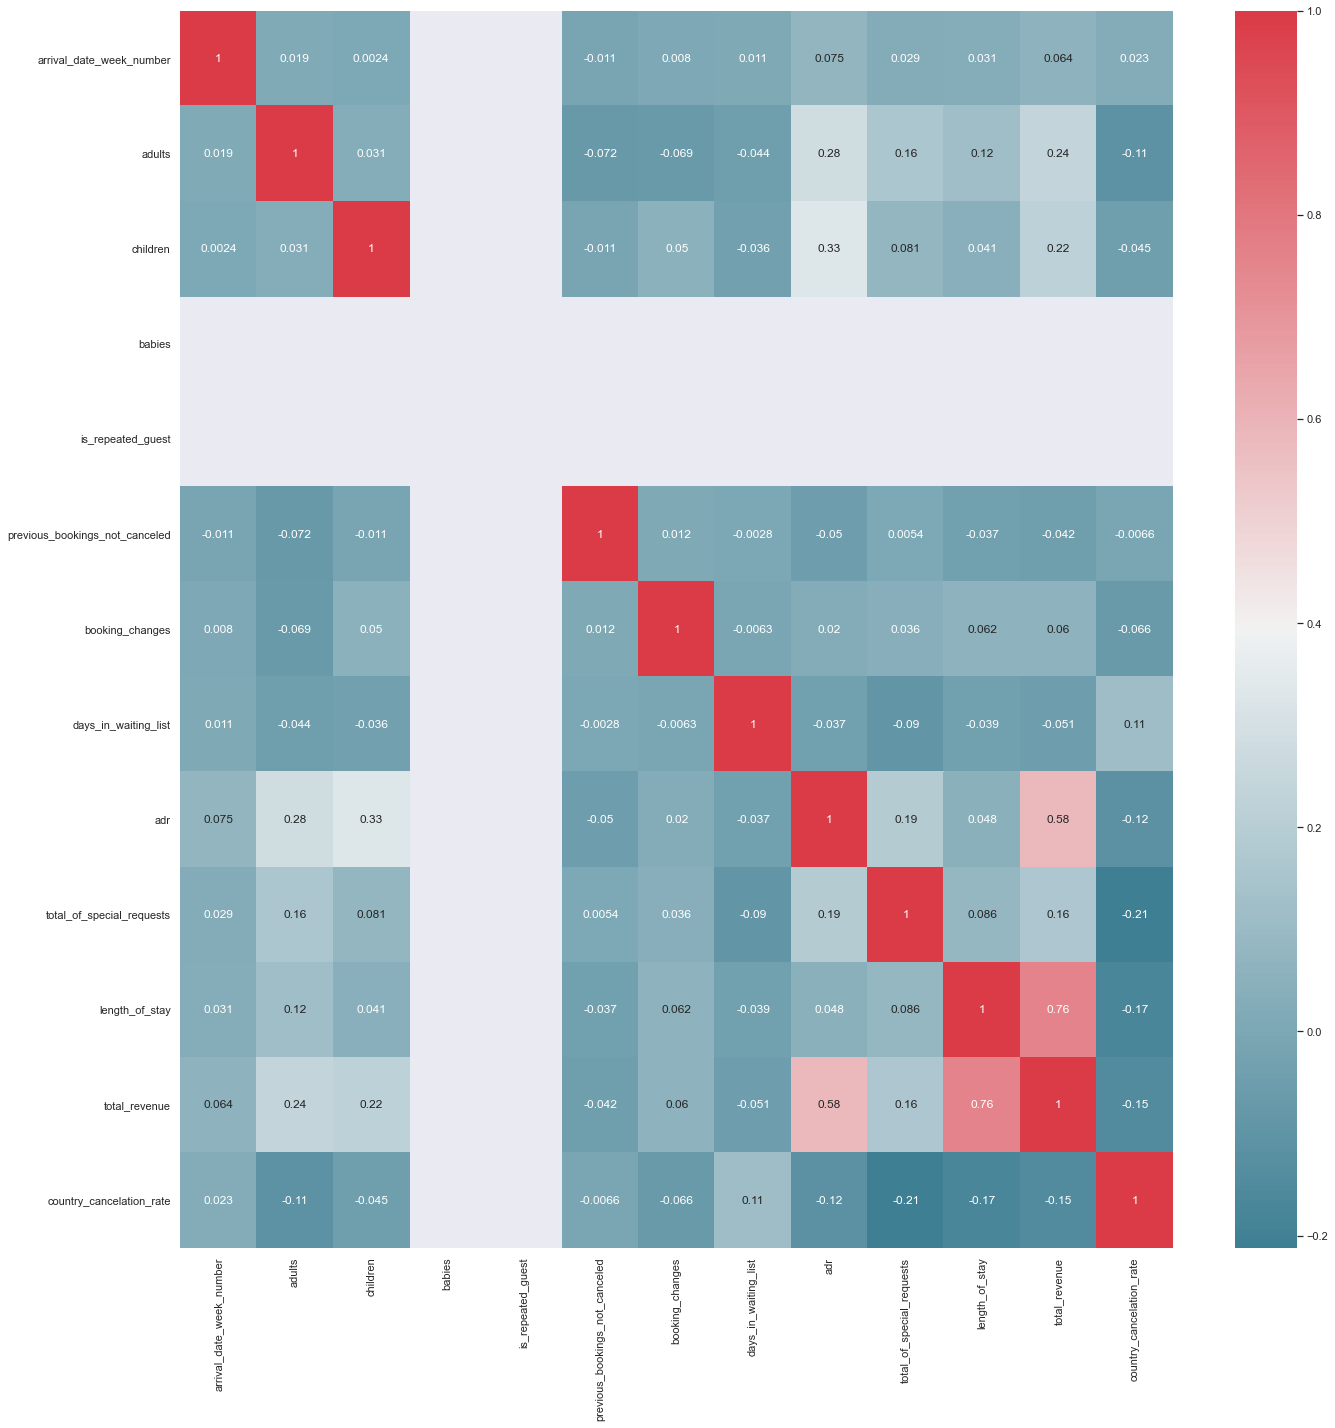

In [29]:
# plot the correlation matrix using seaborn

sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(hotel_no_outliers[hotel_continuous].corr(), cmap=cmap, annot=True)

f.tight_layout()

    # source:
    # copied from asynch notebook

Correlation Matrix:

The correlations matrix plot using the source data sans outliers tells us that there are not many strong relationships between the continuous features. We do observe some colinearity between `length_of_stay` and `total_revenue`, but that is because `total_revenue` is a product of `length_of_stay`.

We will proceed without reducing or combining dimensions any further than we already have as noted below:
```python
# drop the temp columns created in order to create `country_cancelation_rate`
hotel = hotel.drop(['country_count','cancelations','is_canceled_int'], axis=1)


# dropping redundant date columns as this data is now available in `arrival_date`
hotel = hotel.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month'], axis=1)


# dropping redundant stay length columns as this data is now available in 
# `stays_in_week_nights_cat` and `stays_in_weekend_nights_cat`
hotel = hotel.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)


# dropping redundant columns that changed to boolean or categorical or in grouped attributes
hotel = hotel.drop(['company','agent', 'lead_time', 'country', 
                    'previous_cancellations', 'required_car_parking_spaces'], axis=1)

# dropping redundant columns `reservation_status` as it's nearly identical to `is_canceled` - the target in classification
hotel = hotel.drop(['reservation_status'], axis=1)
```

# Data Preparation Part 2

### Describe the final dataset that is used for classification/regression (descriptions of variables included)

# Modeling and Evaluation 1

#### Choose and explain your evaluation metrics you will use. Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

> For our classification task, the target variable of cancelations versus non-cancelations is unbalanced (~30/70) so it will be a better choice to use F1 score - which is the harmonic mean of Recall and Precision - versus the single metrics themselves. We will also use accuracy to compare our model runs. 

> For our regression task we are going to predict length of stay (length_of_stay). We chose regression because the number of nights guests stayed at the hotel length_of_stay is a continous variable.   We will compare against the metrics of RMSE or mean absolute error. We will use RMSE because this metric penalizes large errors in the model (due to squaring first) and having a large error on a predicted length of stay may be catastrophic to the businesses uses of the model. 

# Modeling and Evaluation Part 2

#### Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?) Explain why your chosen method is appropriate or use more than one method as appropriate.

> We will measure the effectiveness of this classification model by using Stratified 10-fold cross validation. The count of cancelations versus non-cancelations is unbalanced (~30/70) and we want to make sure that each fold maintains the same balance as the source data.

> We will measure the effectiveness of this regression model by using 10-fold cross validation.

# Modeling and Evaluation 3

Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). 

### Classification Task: KNN, Nearest Centroid, NaiveBayes, & Decision Tree

#### Feature Selection - Classification
We will use a RandomForest and RFECV for classification for feature selection. For this, we will use `roc_auc` scoring.

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.neighbors import NearestCentroid
from numpy import arange
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

In [172]:
#running cross validation on a basic KNN model, tuning the k hyperparameter
time.time()
for k in range(1,11):
    start_time = time.time()
    clf = KNeighborsClassifier(n_neighbors = k, n_jobs = nj)
    scores_f1 = cross_val_score(clf, train_val_data_clf, train_val_target_clf, cv=10, scoring = 'f1', n_jobs = nj)
    scores_acc = cross_val_score(clf, train_val_data_clf, train_val_target_clf, cv=10, scoring = 'accuracy', n_jobs = nj)
    print('k = ',k)
    print ("mean f1 of cross-validation using train set: ", scores_f1.mean())
    print ("mean accuracy of cross-validation using train set: ", scores_acc.mean())
    print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    

k =  1
mean accuracy of cross-validation using train set:  0.7891054272645799
mean accuracy of cross-validation using train set:  0.8393111903700401
Time to run 483.1612 Seconds
k =  2
mean accuracy of cross-validation using train set:  0.7604293028133983
mean accuracy of cross-validation using train set:  0.8392331698617921
Time to run 453.3442 Seconds
k =  3
mean accuracy of cross-validation using train set:  0.7862058665975582
mean accuracy of cross-validation using train set:  0.840615247436469
Time to run 434.6953 Seconds
k =  4
mean accuracy of cross-validation using train set:  0.7706007306330074
mean accuracy of cross-validation using train set:  0.8417744092732947
Time to run 427.8622 Seconds
k =  5
mean accuracy of cross-validation using train set:  0.7887355845751294
mean accuracy of cross-validation using train set:  0.8440035666518056
Time to run 423.9245 Seconds
k =  6
mean accuracy of cross-validation using train set:  0.7747659317206951
mean accuracy of cross-validation

In [222]:
# KNN basic classifier with best K
clf_val = KNeighborsClassifier(n_neighbors = 5, n_jobs = nj)
clf_val.fit(train_val_data_clf, train_val_target_clf)

KNeighborsClassifier(n_jobs=-1)

Now I'm going to check out how the pairs plot looks with all the features, so I can see if there are any that provide no value in separating the classes.

In [47]:
#combine to full set for plotting
full_train_data_df = pd.DataFrame(train_val_data_clf, columns = data_clf.columns)
full_train_target_df = pd.DataFrame(train_val_target_clf, columns = ['is_canceled'])
full_train_df = pd.concat([full_train_data_df, full_train_target_df], axis = 1, join = 'inner')

Z:\Programs\Anaconda\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
Z:\Programs\Anaconda\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
Z:\Programs\Anaconda\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
Z:\Programs\Anaconda\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


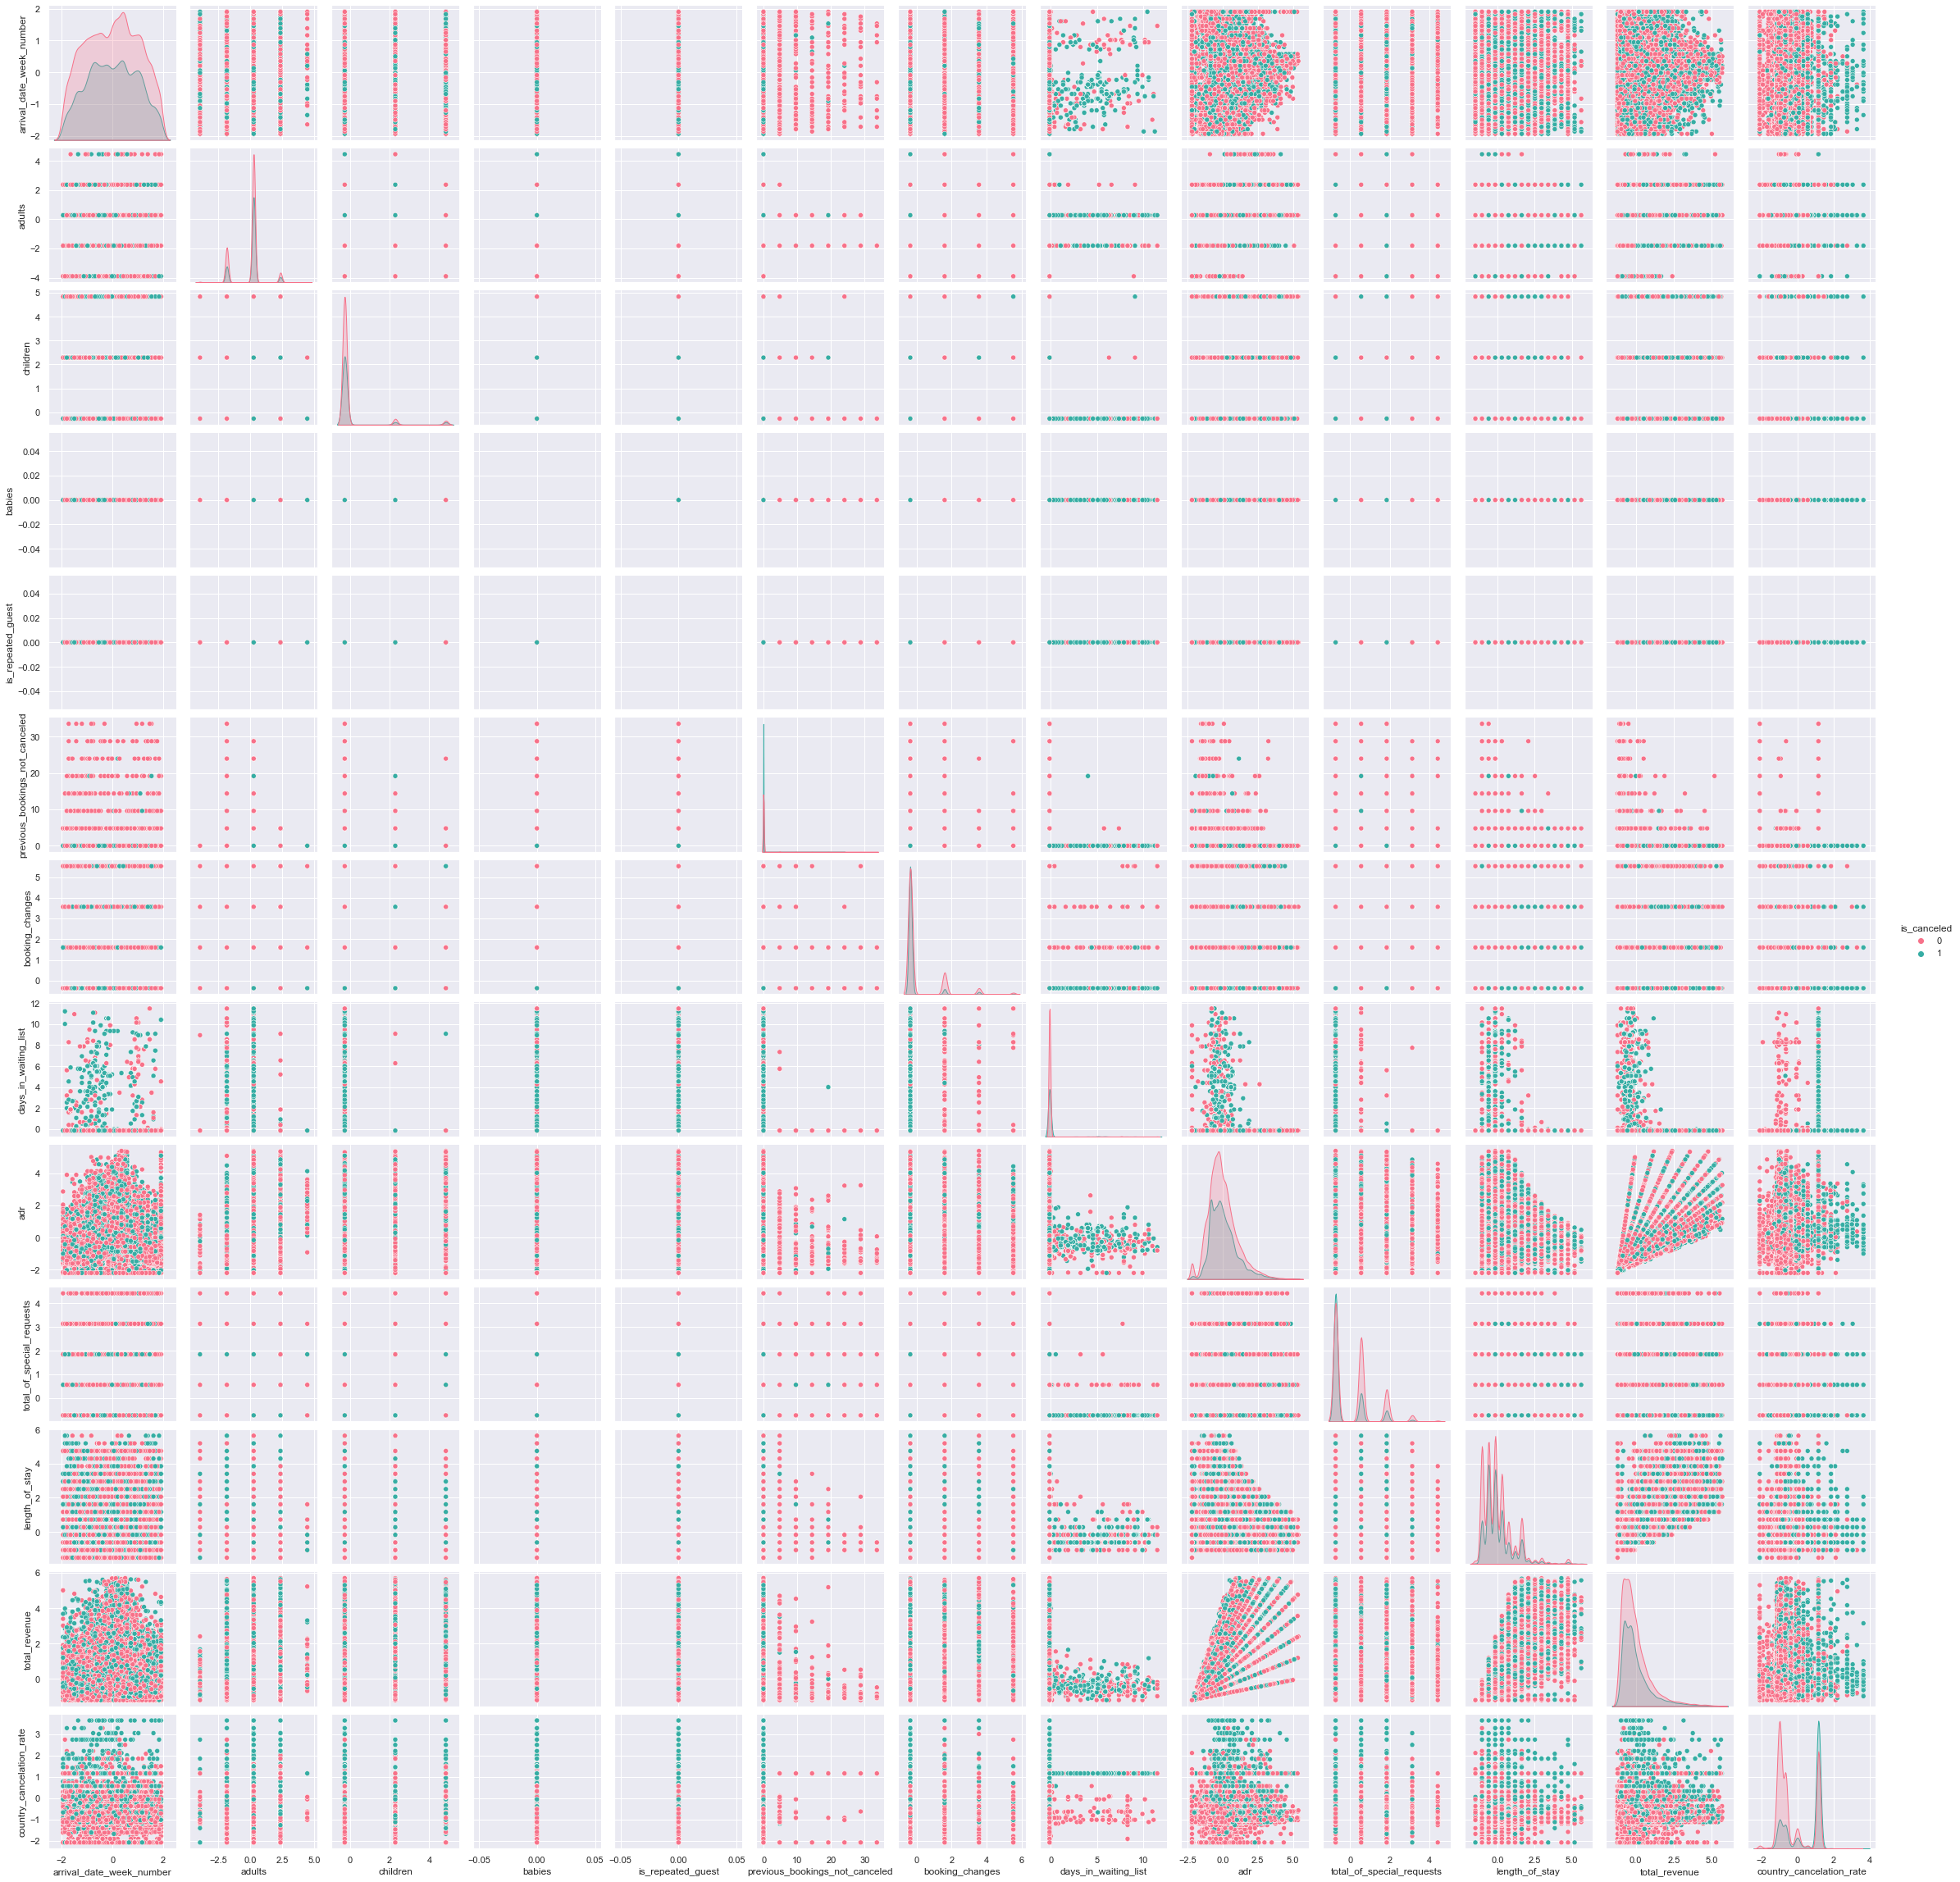

In [203]:
sns.set(color_codes=True)
var = list(hotel_no_outliers[hotel_continuous].columns)
sns.pairplot(full_train_df, hue='is_canceled', vars = var, palette="husl")

The variables "babies" and "is_repeated_guest" have empty plots on the diagonal (which means there is no class separation shown), so I'm going to remove them and check if my scores are the same.

In [229]:
# manually drop the two variables from the training and test data
train_data_dropknn = pd.DataFrame(train_val_data_clf, columns = data_clf.columns).drop(['babies', 'is_repeated_guest'], axis=1)
test_data_dropknn = pd.DataFrame(test_data_clf, columns = data_clf.columns).drop(['babies', 'is_repeated_guest'], axis=1)

In [205]:
#knn with 'babies' and 'is_repeated_guest' removed
time.time()
for k in range(1,11):
    start_time = time.time()
    clf = KNeighborsClassifier(n_neighbors = k, n_jobs = nj)
    scores_f1 = cross_val_score(clf, train_data_dropknn, train_val_target_clf, cv=10, scoring = 'f1', n_jobs = nj)
    scores_acc = cross_val_score(clf, train_data_dropknn, train_val_target_clf, cv=10, scoring = 'accuracy', n_jobs = nj)
    print('k = ',k)
    print ("mean f1 of cross-validation using train set: ", scores_f1.mean())
    print ("mean accuracy of cross-validation using train set: ", scores_acc.mean())
    print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    

k =  1
mean accuracy of cross-validation using train set:  0.7891054272645799
mean accuracy of cross-validation using train set:  0.8393111903700401
Time to run 431.2475 Seconds
k =  2
mean accuracy of cross-validation using train set:  0.7604293028133983
mean accuracy of cross-validation using train set:  0.8392331698617921
Time to run 432.6664 Seconds
k =  3
mean accuracy of cross-validation using train set:  0.7862058665975582
mean accuracy of cross-validation using train set:  0.840615247436469
Time to run 435.9205 Seconds
k =  4
mean accuracy of cross-validation using train set:  0.7706007306330074
mean accuracy of cross-validation using train set:  0.8417744092732947
Time to run 440.0591 Seconds
k =  5
mean accuracy of cross-validation using train set:  0.7887355845751294
mean accuracy of cross-validation using train set:  0.8440035666518056
Time to run 443.1458 Seconds
k =  6
mean accuracy of cross-validation using train set:  0.7747659317206951
mean accuracy of cross-validation

After having removed those two variables, you can see that all our accuracy scores were identical. So, K = 5 remains the best nearest neighbor count to use for our model, with the test accuracy of 84.4%.

In [223]:
#KNN classifier with two vars removed
clf_rem = KNeighborsClassifier(n_neighbors = 5, n_jobs = nj)
clf_rem.fit(train_data_dropknn, train_val_target_clf)

KNeighborsClassifier(n_jobs=-1)

Another method of feature selection is to use RandomForest cross validation. As we are still working on the "is_canceled" variable as our target, we will benefit from RFECV's built-in StratifiedKFold method to split the data into a similar ratio for the estimation. This is the 'cv' parameter.

In [207]:
#import the functions and fit to the training set
start_time = time.time()

# Classification Task

# RandomForest classifier used for feature selection for clf
feat_select_estimator_clf = RandomForestClassifier(random_state=24, n_jobs=nj) 

rfecv_clf = RFECV(estimator=feat_select_estimator_clf,
              cv=10, 
              scoring = 'roc_auc',
              n_jobs=2)
    


rfecv_clf.fit(train_val_data_clf, train_val_target_clf)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    # source:
    # https://stackoverflow.com/questions/55609339/how-to-perform-feature-selection-with-gridsearchcv-in-sklearn-in-python

Time to run 1203.0749 Seconds


In [209]:
print(f'Optimal number of features for classification: {rfecv_clf.n_features_}')
features_clf=list(data_clf.columns[rfecv_clf.support_])
print(f'Features for classification: {features_clf}')

Optimal number of features for classification: 49
Features for classification: ['arrival_date_week_number', 'adults', 'children', 'booking_changes', 'days_in_waiting_list', 'adr', 'total_of_special_requests', 'length_of_stay', 'total_revenue', 'country_cancelation_rate', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_Direct', 'distribution_channel_TA/TO', 'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G', 'assigned_room_type_B', 'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E', 'assigned_room_type_F', 'assigned_room_type_G', 'deposit_type_Non Refund', 'customer_type_Transient', 'customer_type_Transient-Party', 'stays_in_week_nights_bool_1', 'stays_in_weekend_nights_bool_1', 'company_booking

In [211]:
#knn with first feature selection results
time.time()
for k in range(1,11):
    start_time = time.time()
    clf = KNeighborsClassifier(n_neighbors = k, n_jobs = nj)
    scores_f1 = cross_val_score(clf, full_train_data_df[features_clf], train_val_target_clf, cv=10, scoring = 'f1', n_jobs = nj)
    scores_acc = cross_val_score(clf, full_train_data_df[features_clf], train_val_target_clf, cv=10, scoring = 'accuracy', n_jobs = nj)
    print('k = ',k)
    print ("mean f1 of cross-validation using train set: ", scores_f1.mean())
    print ("mean accuracy of cross-validation using train set: ", scores_acc.mean())
    print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    

k =  1
mean accuracy of cross-validation using train set:  0.7887750475220322
mean accuracy of cross-validation using train set:  0.8390102541239411
Time to run 347.2355 Seconds
k =  2
mean accuracy of cross-validation using train set:  0.760184910214306
mean accuracy of cross-validation using train set:  0.8390213999108337
Time to run 353.147 Seconds
k =  3
mean accuracy of cross-validation using train set:  0.7855788734576035
mean accuracy of cross-validation using train set:  0.8400579580918413
Time to run 354.5765 Seconds
k =  4
mean accuracy of cross-validation using train set:  0.7698758284076874
mean accuracy of cross-validation using train set:  0.8412728488631297
Time to run 358.7791 Seconds
k =  5
mean accuracy of cross-validation using train set:  0.7883376128020656
mean accuracy of cross-validation using train set:  0.8436134641105661
Time to run 364.7462 Seconds
k =  6
mean accuracy of cross-validation using train set:  0.7745264253137011
mean accuracy of cross-validation 

In [224]:
#KNN classifier with RFECV performed
clf_ftsel = KNeighborsClassifier(n_neighbors = 5, n_jobs = nj)
clf_ftsel.fit(full_train_data_df[features_clf], train_val_target_clf)

KNeighborsClassifier(n_jobs=-1)

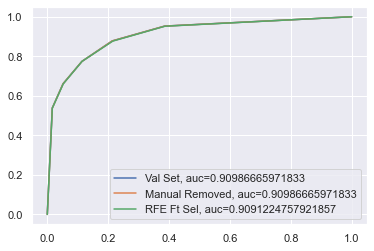

In [230]:
#plot the ROC curves on the test data. it has to be converted to a pd dataframe to subset so I do that first.

test_data_clf_df = pd.DataFrame(test_data_clf, columns = data_clf.columns)

Y_pred_val_prob = clf_val.predict_proba(test_data_clf)[::,1]
Y_pred_rem_prob = clf_rem.predict_proba(test_data_dropknn)[::,1]
Y_pred_ftsel_prob = clf_ftsel.predict_proba(test_data_clf_df[features_clf])[::,1]

fpr_val, tpr_val, _ = metrics.roc_curve(test_target_clf,  Y_pred_val_prob)
fpr_rem, tpr_rem, _ = metrics.roc_curve(test_target_clf,  Y_pred_rem_prob)
fpr_ftsel, tpr_ftsel, _ = metrics.roc_curve(test_target_clf,  Y_pred_ftsel_prob)

auc_val = metrics.roc_auc_score(test_target_clf, Y_pred_val_prob)
auc_rem = metrics.roc_auc_score(test_target_clf, Y_pred_rem_prob)
auc_ftsel = metrics.roc_auc_score(test_target_clf, Y_pred_ftsel_prob)


plt.plot(fpr_val,tpr_val,label="Val Set, auc="+str(auc_val))
plt.plot(fpr_rem,tpr_rem,label="Manual Removed, auc="+str(auc_rem))
plt.plot(fpr_ftsel,tpr_ftsel,label="RFE Ft Sel, auc="+str(auc_ftsel))

plt.legend(loc=4) 


Now that we've compared different KNN models, and found that either of the initial KNN models has the largest area under the curve (auc). Seeing as the first model runs faster than the one with the two variables removed, let's see how it performs on the test data.

In [231]:
# applying the final KNN model to our test data

time.time()

start_time = time.time()
Y_pred = clf_val.predict(test_data_clf)
f1 = f1_score(test_target_clf, Y_pred)
print ('Test set f1 score: ', f1)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set accuracy:  0.7893977641543455
Time to run 34.1115 Seconds


Our f1 score for this classification is 78.9%.

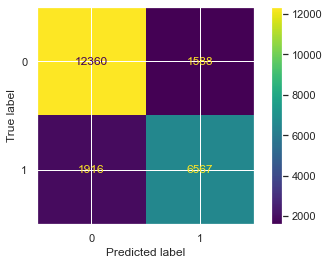

In [232]:
cmd(confusion_matrix(test_target_clf, Y_pred)).plot()

Another classification method branching off KNN is nearest centroid. Let's see below how it performs.

#### Nearest Centroid

We're using gridsearch crossvalidation below because the number of parameter options we are feeding in is not more than 3. This is a limitation in the gridsearchcv() function.

In [37]:
# use grisearchCV to hyperparameter tune.
time.time()

start_time = time.time()
grid = dict()
grid['shrink_threshold'] = arange(0, .01, .1)
grid['metric'] = ['euclidean','manhattan','cosine']
# define search
search_f1 = GridSearchCV(NearestCentroid(), grid, scoring='f1', cv=10, n_jobs=-1)
search_acc = GridSearchCV(NearestCentroid(), grid, scoring='accuracy', cv=10, n_jobs=-1)
# perform the search
results_f1 = search_f1.fit(train_val_data_clf, train_val_target_clf)
results_acc = search_acc.fit(train_val_data_clf, train_val_target_clf)
# summarize
print('Mean Accuracy: %.3f' % results_acc.best_score_)
print('Config: %s' % results_acc.best_params_)
print('Mean f1: %.3f' % results_f1.best_score_)
print('Config f1: %s' % results_f1.best_params_)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Z:\Programs\Anaconda\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


Mean Accuracy: 0.790
Config: {'metric': 'euclidean', 'shrink_threshold': 0.0}
Mean f1: 0.710
Config f1: {'metric': 'cosine', 'shrink_threshold': 0.0}
Time to run 2.5548 Seconds


In [43]:
# employ gridsearch for hyperparameter tuning in the Nearest Centroid classifier

time.time()

start_time = time.time()
grid = dict()
grid['shrink_threshold'] = arange(0, .01, .1)
grid['metric'] = ['euclidean','manhattan','cosine']
# define search
search_f1 = GridSearchCV(NearestCentroid(), grid, scoring='f1', cv=10, n_jobs=-1)
search_acc = GridSearchCV(NearestCentroid(), grid, scoring='accuracy', cv=10, n_jobs=-1)
# perform the search
results_f1 = search_f1.fit(full_train_data_df[features_clf], train_val_target_clf)
results_acc = search_acc.fit(full_train_data_df[features_clf], train_val_target_clf)
# summarize
print('Mean Accuracy: %.3f' % results_acc.best_score_)
print('Config: %s' % results_acc.best_params_)
print('Mean f1: %.3f' % results_f1.best_score_)
print('Config f1: %s' % results_f1.best_params_)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Z:\Programs\Anaconda\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


Mean Accuracy: 0.790
Config: {'metric': 'euclidean', 'shrink_threshold': 0.0}
Mean f1: 0.710
Config f1: {'metric': 'cosine', 'shrink_threshold': 0.0}
Time to run 2.5644 Seconds


The best distance metric for both variations of our nearest centroid models is euclidean based on accuracy, with a shrink threshold of 0. The best distance metric for both variations of our nearest centroid models is cosine based on f1 score, with a shrink threshold of 0. There is no significant advantage to removing the features selected from the RFECV that we ran. So now let's take a look at the ROC curves for both models on our test data. In order to plot ROC, an ensemble method called bagging must be employed to get prediction probabilities for plotting. 

Z:\Programs\Anaconda\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
Z:\Programs\Anaconda\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
Z:\Programs\Anaconda\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
Z:\Programs\Anaconda\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for m

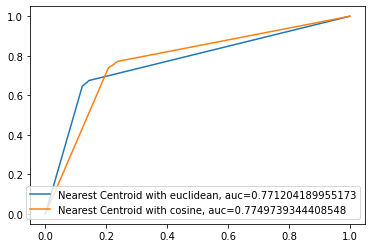

In [45]:
#bagging to get probabilities for an ROC curve
clf_bag_ncent = BaggingClassifier(base_estimator=NearestCentroid(metric = 'euclidean', shrink_threshold = 0),
                        n_estimators=10, random_state=42).fit(train_val_data_clf, train_val_target_clf)


Y_pred_ncent_prob = clf_bag_ncent.predict_proba(test_data_clf)[::,1]
fpr_ncent, tpr_ncent, _ = metrics.roc_curve(test_target_clf,  Y_pred_ncent_prob)
auc_ncent = metrics.roc_auc_score(test_target_clf, Y_pred_ncent_prob)


clf_bag_ncent_f1 = BaggingClassifier(base_estimator=NearestCentroid(metric = 'cosine', shrink_threshold = 0),
                        n_estimators=10, random_state=42).fit(train_val_data_clf, train_val_target_clf)


Y_pred_ncent_f1_prob = clf_bag_ncent_f1.predict_proba(test_data_clf)[::,1]
fpr_ncent_f1, tpr_ncent_f1, _ = metrics.roc_curve(test_target_clf,  Y_pred_ncent_f1_prob)
auc_ncent_f1 = metrics.roc_auc_score(test_target_clf, Y_pred_ncent_f1_prob)

plt.plot(fpr_ncent,tpr_ncent,label="Nearest Centroid with euclidean, auc="+str(auc_ncent))
plt.plot(fpr_ncent_f1,tpr_ncent_f1,label="Nearest Centroid with cosine, auc="+str(auc_ncent_f1))



plt.legend(loc=4) 

With an AUC of .7749, the cosine distance metric wins out between the two. However, this clearly will not be the best classification model, as you can see that the ROC curves immediately trend rightward on the x-axis. Because of this heavy lean, we aren't hopeful about this model's performance. But let's apply it to our test set to see the results anyway.

Test set f1 score:  0.7115191986644407
Time to run 0.375 Seconds


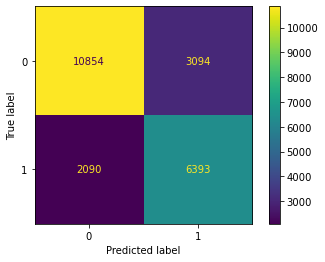

In [46]:
time.time()

start_time = time.time()
Y_pred = clf_bag_ncent_f1.predict(test_data_clf)
f1 = f1_score(test_target_clf, Y_pred)
print ('Test set f1 score: ', f1)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

cmd(confusion_matrix(test_target_clf, Y_pred)).plot()

As assumed, the model only achieved an f1 score of 71.15%

#### Gaussian Naive Bayes

Since we scaled our data using mean/stddev with StandardScaler(), our results contained some negative values. Gaussian Naive Bayes is the only NB implementation possible here, given that we have negative values. Naive Bayes is worth taking a look at, considering how little correlation there seems to be among the variables in our dataset. We found it surprising that there is not much correlation there, but if the attributes indeed do not interact much, then NB will perform well.

In [37]:
smoothers = [.0001, .001, .01, .1, 1, 5, 10]
time.time()
for sm in smoothers:
    start_time = time.time()
    clf_GNB = GaussianNB(var_smoothing=sm)
    scores_f1 = cross_val_score(clf_GNB, train_val_data_clf, train_val_target_clf, cv=10, scoring = 'f1', n_jobs = nj)
    scores_acc = cross_val_score(clf_GNB, train_val_data_clf, train_val_target_clf, cv=10, scoring = 'accuracy', n_jobs = nj)
    print ("smoother used: ", sm)
    print ("mean f1 of cross-validation using train set: ", scores_f1.mean())
    print ("mean accuracy of cross-validation using train set: ", scores_acc.mean())
    print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    


smoother used:  0.0001
mean f1 of cross-validation using train set:  0.547126881095261
mean accuracy of cross-validation using train set:  0.7596633972358449
Time to run 1.5042 Seconds
smoother used:  0.001
mean f1 of cross-validation using train set:  0.5530041453186938
mean accuracy of cross-validation using train set:  0.7606553722692821
Time to run 1.4105 Seconds
smoother used:  0.01
mean f1 of cross-validation using train set:  0.5942451084350487
mean accuracy of cross-validation using train set:  0.7668189924208648
Time to run 1.3783 Seconds
smoother used:  0.1
mean f1 of cross-validation using train set:  0.6689666498332387
mean accuracy of cross-validation using train set:  0.746522514489523
Time to run 1.3794 Seconds
smoother used:  1
mean f1 of cross-validation using train set:  0.6691000953083379
mean accuracy of cross-validation using train set:  0.7182790905037895
Time to run 1.5181 Seconds
smoother used:  5
mean f1 of cross-validation using train set:  0.6240327907498451


With the smoother set to 1, we get our best f1 score on the validation set.

In [62]:
smoothers = [.0001, .001, .01, .1, 1, 5, 10]
time.time()
for sm in smoothers:
    start_time = time.time()
    clf_GNB = GaussianNB(var_smoothing=sm)
    scores_f1 = cross_val_score(clf_GNB, full_train_data_df[features_clf], train_val_target_clf, cv=10, scoring = 'f1', n_jobs = nj)
    scores_acc = cross_val_score(clf_GNB, full_train_data_df[features_clf], train_val_target_clf, cv=10, scoring = 'accuracy', n_jobs = nj)
    print ("smoother used: ", sm)
    print ("mean f1 of cross-validation using train set: ", scores_f1.mean())
    print ("mean accuracy of cross-validation using train set: ", scores_acc.mean())
    print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    


smoother used:  0.0001
mean f1 of cross-validation using train set:  0.6491145498040979
mean accuracy of cross-validation using train set:  0.6676437806509139
Time to run 3.4377 Seconds
smoother used:  0.001
mean f1 of cross-validation using train set:  0.6555759112609747
mean accuracy of cross-validation using train set:  0.6830026749888543
Time to run 1.3651 Seconds
smoother used:  0.01
mean f1 of cross-validation using train set:  0.6597944124761499
mean accuracy of cross-validation using train set:  0.69541908158716
Time to run 1.2704 Seconds
smoother used:  0.1
mean f1 of cross-validation using train set:  0.6578752023251075
mean accuracy of cross-validation using train set:  0.6883972358448507
Time to run 1.363 Seconds
smoother used:  1
mean f1 of cross-validation using train set:  0.6543842988063526
mean accuracy of cross-validation using train set:  0.6662951404369147
Time to run 1.3631 Seconds
smoother used:  5
mean f1 of cross-validation using train set:  0.6835554972273286
m

With the smoother set to 5 on the reduced feature set from RFECV, we get our best f1 score. So let's check out the ROC curves for our test data.

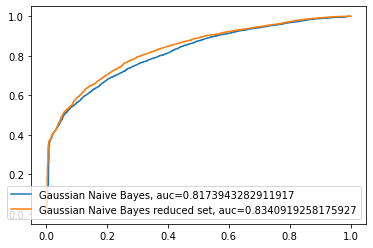

In [67]:
#ROC curves for Gaussian NB

clf_GNB = GaussianNB(var_smoothing=1)
clf_GNB.fit(train_val_data_clf, train_val_target_clf)

Y_pred_GNB_prob = clf_GNB.predict_proba(test_data_clf)[::,1]
fpr_GNB, tpr_GNB, _ = metrics.roc_curve(test_target_clf,  Y_pred_GNB_prob)
auc_GNB = metrics.roc_auc_score(test_target_clf, Y_pred_GNB_prob)
plt.plot(fpr_GNB,tpr_GNB,label="Gaussian Naive Bayes, auc="+str(auc_GNB))

#reduced set
clf_GNB_red = GaussianNB(var_smoothing=5)
clf_GNB_red.fit(full_train_data_df[features_clf], train_val_target_clf)

Y_pred_GNB_red_prob = clf_GNB_red.predict_proba(test_data_clf_df[features_clf])[::,1]
fpr_GNB_red, tpr_GNB_red, _ = metrics.roc_curve(test_target_clf,  Y_pred_GNB_red_prob)
auc_GNB_red = metrics.roc_auc_score(test_target_clf, Y_pred_GNB_red_prob)
plt.plot(fpr_GNB_red,tpr_GNB_red,label="Gaussian Naive Bayes reduced set, auc="+str(auc_GNB_red))

plt.legend(loc=4) 

Our AUC of .834 for the reduced set is better than .817 with the full set, and looks great compared to the NearestCentroid classifier, as the curve doesn't begin until about .4 on the y-axis. However, it still isn't as good as the first KNN. Finally, let's run it on our test set and get the f1 score.

In [34]:
start_time = time.time()
clf_GNB = GaussianNB(var_smoothing=1)
clf_GNB.fit(train_val_data_clf, train_val_target_clf)
Y_pred = clf_GNB.predict(test_data_clf)
f1 = f1_score(test_target_clf, Y_pred)
print ('Test set f1 score: ', f1)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score:  0.672291808605419
Time to run 0.111 Seconds


In [70]:
start_time = time.time()
clf_GNB = GaussianNB(var_smoothing=5)
clf_GNB.fit(full_train_data_df[features_clf], train_val_target_clf)
Y_pred = clf_GNB.predict(test_data_clf_df[features_clf])
f1 = f1_score(test_target_clf, Y_pred)
print ('Test set f1 score: ', f1)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score:  0.6863199408429873
Time to run 0.1365 Seconds


These were disappointing f1 scores, and at 68.6% for the higher one it is nowhere near our KNN test f1 score of 78.9%. The naive Bayes assumption of no interaction looks to not have been correct, hence our model underperformed.

#### Decision Tree

In [22]:
#Decision Tree classifier, including hyperparameter tuning


time.time()

start_time = time.time()
grid = dict()
grid['criterion'] = ['gini', 'entropy']
grid['splitter'] = ['best', 'random']
grid['max_features'] = ['auto', 'sqrt', 'log2']

# define search
search_f1 = GridSearchCV(tree.DecisionTreeClassifier(), grid, scoring='f1', cv=10, n_jobs=-1)
search_acc = GridSearchCV(tree.DecisionTreeClassifier(), grid, scoring='accuracy', cv=10, n_jobs=-1)
# perform the search
results_f1 = search_f1.fit(train_val_data_clf, train_val_target_clf)
results_acc = search_acc.fit(train_val_data_clf, train_val_target_clf)
# summarize
print('Mean Accuracy: %.3f' % results_acc.best_score_)
print('Config: %s' % results_acc.best_params_)
print('Mean f1: %.3f' % results_f1.best_score_)
print('Config f1: %s' % results_f1.best_params_)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Mean Accuracy: 0.838
Config: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}
Mean f1: 0.785
Config f1: {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'best'}
Time to run 13.9615 Seconds


The best performing model based on accuracy used the `'entropy'`, `'auto'`, and `'best'` hyperparameters. The best performing model based on f1 score used the `'entropy'`, `'sqrt'`, and `'best'` hyperparameters. Let's see how their ROC curves look.

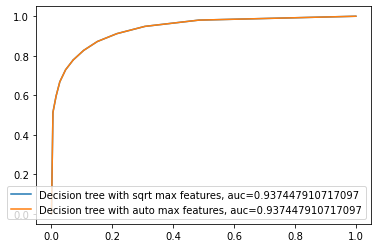

In [23]:
#bagging to get probabilities for an ROC curve
clf_bag_dtree_acc = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_features = 'auto', random_state=24),
                        n_estimators=10, random_state=42).fit(train_val_data_clf, train_val_target_clf)


Y_pred_dtree_acc_prob = clf_bag_dtree_acc.predict_proba(test_data_clf)[::,1]
fpr_dtree_acc, tpr_dtree_acc, _ = metrics.roc_curve(test_target_clf,  Y_pred_dtree_acc_prob)
auc_dtree_acc = metrics.roc_auc_score(test_target_clf, Y_pred_dtree_acc_prob)


clf_bag_dtree_f1 = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_features = 'sqrt', random_state=24),
                        n_estimators=10, random_state=42).fit(train_val_data_clf, train_val_target_clf)


Y_pred_dtree_f1_prob = clf_bag_dtree_f1.predict_proba(test_data_clf)[::,1]
fpr_dtree_f1, tpr_ncent_f1, _ = metrics.roc_curve(test_target_clf,  Y_pred_dtree_f1_prob)
auc_dtree_f1 = metrics.roc_auc_score(test_target_clf, Y_pred_dtree_f1_prob)

plt.plot(fpr_dtree_acc,tpr_dtree_acc,label="Decision tree with sqrt max features, auc="+str(auc_dtree_acc))
plt.plot(fpr_dtree_f1,tpr_ncent_f1,label="Decision tree with auto max features, auc="+str(auc_dtree_f1))



plt.legend(loc=4) 

Clearly, the max number of features method had no impact on the AUC since they are both identical at .937 which is our best so far. Let's go ahead and apply them to the test set.

In [24]:
start_time = time.time()
clf_dtc_1 = tree.DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_features = 'auto', random_state=24)
clf_dtc_1.fit(train_val_data_clf, train_val_target_clf)
Y_pred = clf_dtc_1.predict(test_data_clf)
f1 = f1_score(test_target_clf, Y_pred)
print ('Test set f1 score: ', f1)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score:  0.7928521043968962
Time to run 0.147 Seconds


In [25]:
start_time = time.time()
clf_dtc_2 = tree.DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_features = 'sqrt', random_state=24)
clf_dtc_2.fit(train_val_data_clf, train_val_target_clf)
Y_pred = clf_dtc_2.predict(test_data_clf)
f1 = f1_score(test_target_clf, Y_pred)
print ('Test set f1 score: ', f1)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score:  0.7928521043968962
Time to run 0.145 Seconds


As expected, they have the same f1 score result of 79.28%. This is our highest f1 score of all the classification models, so the Decision Tree classifier is our chosen method.

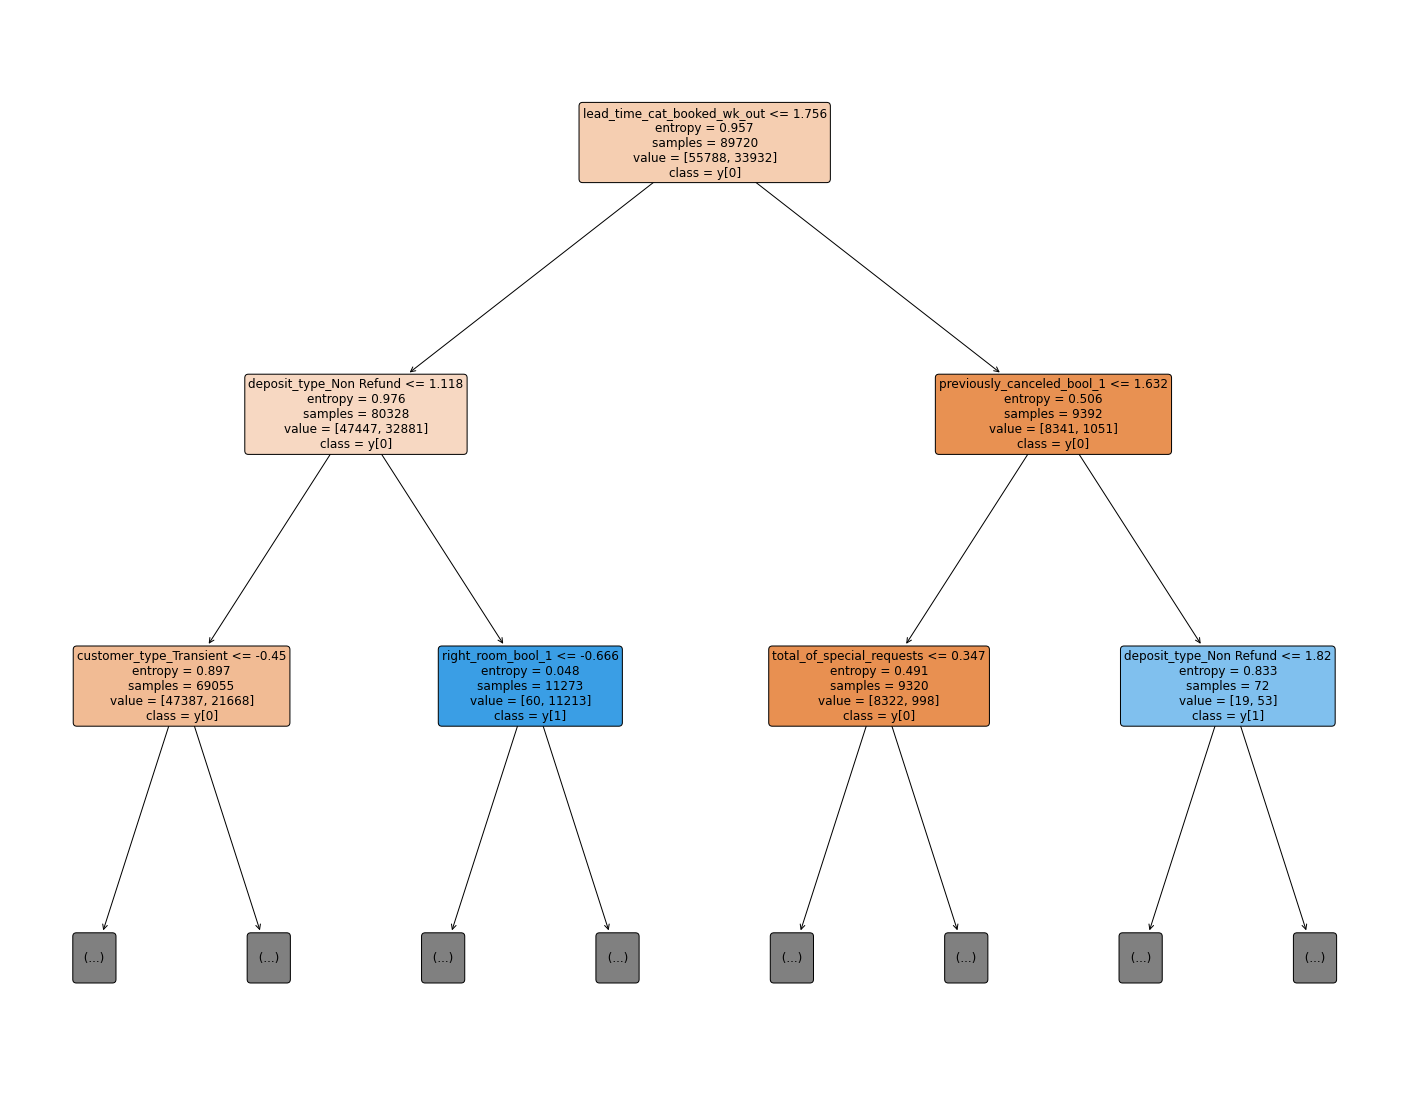

In [26]:
# sourced from https://mljar.com/blog/visualize-decision-tree/

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_dtc_1,
                   max_depth= 2,
                   feature_names=test_data_clf_df.columns,  
                   class_names=True,
                   filled=True,
                  rounded = True,
                  fontsize = 12)


Above is a very small representation of our enormous decision tree to see how the splitting initially starts. Bluer boxes are 'is_canceled' as 1, and Orange boxes are 0. Let's take a look at a deeper tree and see what that looks like.

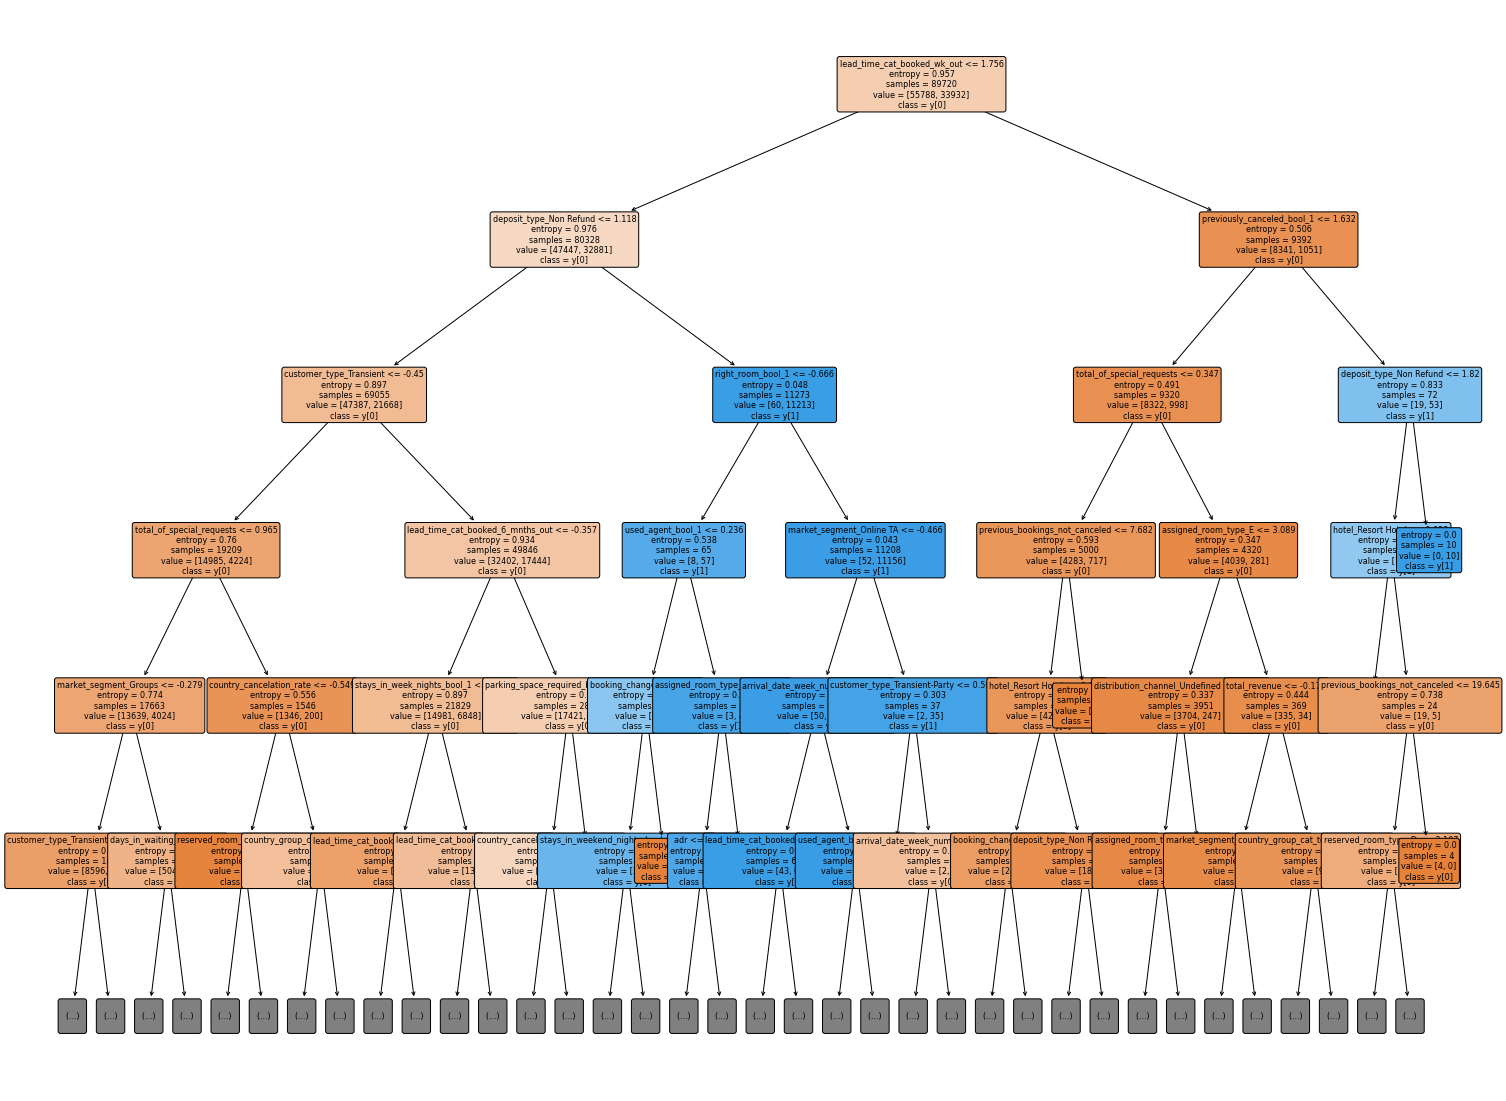

In [31]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_dtc_1,
                   max_depth= 5,
                   feature_names=test_data_clf_df.columns,  
                   class_names=True,
                   filled=True,
                  rounded = True,
                  fontsize = 8)

In [58]:
importance = clf_dtc_1.tree_.compute_feature_importances(normalize=False)

importance_df = pd.DataFrame(importance, index=full_train_data_df.columns, 
                      columns=["Importance"])

print(importance_df.sort_values(by=['Importance'], ascending = False))

                          Importance
deposit_type_Non Refund     0.178087
country_cancelation_rate    0.097735
arrival_date_week_number    0.085768
adr                         0.080883
total_revenue               0.078478
...                              ...
reserved_room_type_L        0.000026
babies                      0.000000
market_segment_Undefined    0.000000
is_repeated_guest           0.000000
assigned_room_type_L        0.000000

[66 rows x 1 columns]


The tree becomes nearly impossible to fully follow starting at a depth of 5 nodes away from the root. Visually, you can already see that the distribution of the two classes is like that of the source data. The number of 'is_canceled' = 0 is nearing double that of 'is_canceled' = 1 in the source data, and the blue vs orange representation here demonstrates a similar trend. However, with our model not being 100% successful, the distribution looks to still favor the 0 value a bit more than 1. The strongest initial indicator according to this tree looks like a guest having a non-refundable deposit put down and right_room_bool_1 meaning that according to the data we have, a guest having the right room assigned to them is more likely to cancel their reservation. This is supported by the feature importances listed above, as the deposit_type_Non Refund feature has the highest importance. Without domain expertise this doesn't seem to make sense, however there may be some further data that hasn't been anonymized which could shed more light on why this is the case.

### Regression Task: KNN, OLS, Random Forest

#### Feature Selection - Regression
We will use a Ridge Regresssion and RFECV for regression feature selection. For this, we will use `neg_root_mean_squared_error` scoring.

#### Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! (Hyperparameter tuning and gridsearchcv)

# Modeling and Evaluation Part 4

#### Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model

> List of Visualizations:
>    - ROC (Classification) 

>    - KNN Viz https://towardsdatascience.com/knn-visualization-in-just-13-lines-of-code-32820d72c6b6

>    - SE Link for Regression Viz https://stats.stackexchange.com/questions/89747/how-to-describe-or-visualize-a-multiple-linear-regression-model

>    - Confusion Matrices as heat maps (Classification) https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

>    - Correlation Matrix heat maps (Regression)
    

# Modeling and Evaluation Part 5

### Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another?

> Better on Metrics?

> Better on Time?

> Sparse vs Non

> Model Specific https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms, https://discuss.analyticsvidhya.com/t/which-one-to-use-randomforest-vs-svm-vs-knn/2897/3, https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

####  Is the difference significant with 95% confidence? proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

> Comparing on Statistics: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/

# Modeling and Evaluation Part 6

### Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task

### Do we need to this for every model iteration? ASK HIM ON THURSDAY

# Deployment NEIL GOT THIS

### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?

> Have a discussion about scope of use

### How would you measure the model's value if it was used by these parties?

###  How would your deploy your model for interested parties? What other datashould be collected? How often would the model need to be updated, etc.?

# Exceptional Work